In [1]:
from common import *
from matplotlib import pyplot as plt
import smart_open

In [2]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [ ]:
def iter_docs(fnames):
    for i, fn in enumerate(fnames):
#         logging.info("%s: " % i + fn)
        with GzipFile(fn, 'rb') as f:
            docs = ujson.loads(f.read())
        for k,doc in docs.items():
            yield k,doc

                
class Documents(object):
    def __init__(self, folder, tokens_only=False):
        self.folder = folder
        self.tokens_only = tokens_only
 
    def __iter__(self):
        fnames = glob(join(self.folder, '*.json.gz'))
        for k, doc in iter_docs(fnames):
            unlisted = [w for s in doc for w in s]
            if self.tokens_only:
                yield unlisted
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(unlisted, [k])

In [ ]:
folder = join(DATA_FOLDER, 'documents/')

model = Doc2Vec(Documents(folder), size=200, window=50, min_count=5, dm=0, workers=cpu_count, iter=10)

2017-09-29 19:11:37,529 [MainThread  ] [INFO ]  collecting all words and their counts
2017-09-29 19:11:37,601 [MainThread  ] [INFO ]  PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-09-29 19:11:42,969 [MainThread  ] [INFO ]  PROGRESS: at example #10000, processed 5214517 words (971589/s), 113415 word types, 10000 tags
2017-09-29 19:11:48,809 [MainThread  ] [INFO ]  PROGRESS: at example #20000, processed 10791718 words (955104/s), 157599 word types, 20000 tags
2017-09-29 19:11:58,078 [MainThread  ] [INFO ]  PROGRESS: at example #30000, processed 19494360 words (939013/s), 197295 word types, 30000 tags
2017-09-29 19:12:09,724 [MainThread  ] [INFO ]  PROGRESS: at example #40000, processed 30923454 words (981544/s), 249001 word types, 40000 tags
2017-09-29 19:12:22,588 [MainThread  ] [INFO ]  PROGRESS: at example #50000, processed 42448329 words (895967/s), 299432 word types, 50000 tags
2017-09-29 19:12:38,710 [MainThread  ] [INFO ]  PROGRESS: at example #60000,

2017-09-29 19:28:54,748 [MainThread  ] [INFO ]  PROGRESS: at example #800000, processed 929731213 words (832346/s), 2169109 word types, 800000 tags
2017-09-29 19:29:07,793 [MainThread  ] [INFO ]  PROGRESS: at example #810000, processed 941309055 words (887565/s), 2179429 word types, 810000 tags
2017-09-29 19:29:22,104 [MainThread  ] [INFO ]  PROGRESS: at example #820000, processed 952679669 words (794616/s), 2188799 word types, 820000 tags
2017-09-29 19:29:38,744 [MainThread  ] [INFO ]  PROGRESS: at example #830000, processed 967477041 words (889359/s), 2202600 word types, 830000 tags
2017-09-29 19:29:45,987 [MainThread  ] [INFO ]  PROGRESS: at example #840000, processed 973898072 words (886700/s), 2224883 word types, 840000 tags
2017-09-29 19:30:03,180 [MainThread  ] [INFO ]  PROGRESS: at example #850000, processed 987901080 words (814489/s), 2237331 word types, 850000 tags
2017-09-29 19:30:14,148 [MainThread  ] [INFO ]  PROGRESS: at example #860000, processed 997620500 words (886283/

2017-09-29 19:41:12,737 [MainThread  ] [INFO ]  PROGRESS: at 0.00% examples, 6317 words/s, in_qsize 6, out_qsize 0
2017-09-29 19:41:13,755 [MainThread  ] [INFO ]  PROGRESS: at 0.02% examples, 335544 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:41:14,759 [MainThread  ] [INFO ]  PROGRESS: at 0.02% examples, 418538 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:41:16,358 [MainThread  ] [INFO ]  PROGRESS: at 0.03% examples, 345801 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:41:17,361 [MainThread  ] [INFO ]  PROGRESS: at 0.04% examples, 444479 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:41:19,057 [MainThread  ] [INFO ]  PROGRESS: at 0.04% examples, 444298 words/s, in_qsize 0, out_qsize 1
2017-09-29 19:41:20,059 [MainThread  ] [INFO ]  PROGRESS: at 0.05% examples, 487547 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:41:21,067 [MainThread  ] [INFO ]  PROGRESS: at 0.05% examples, 477740 words/s, in_qsize 2, out_qsize 0
2017-09-29 19:41:22,077 [MainThread  ] [INFO ]  PROGRESS: at 0.06%

2017-09-29 19:46:49,704 [MainThread  ] [INFO ]  PROGRESS: at 1.34% examples, 468149 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:50,723 [MainThread  ] [INFO ]  PROGRESS: at 1.34% examples, 468079 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:51,779 [MainThread  ] [INFO ]  PROGRESS: at 1.35% examples, 468171 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:53,669 [MainThread  ] [INFO ]  PROGRESS: at 1.36% examples, 466837 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:54,671 [MainThread  ] [INFO ]  PROGRESS: at 1.36% examples, 468004 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:55,703 [MainThread  ] [INFO ]  PROGRESS: at 1.37% examples, 469239 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:57,134 [MainThread  ] [INFO ]  PROGRESS: at 1.37% examples, 467860 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:58,145 [MainThread  ] [INFO ]  PROGRESS: at 1.38% examples, 469064 words/s, in_qsize 0, out_qsize 0
2017-09-29 19:46:59,223 [MainThread  ] [INFO ]  PROGRESS: at 1.3

In [ ]:
model.save('../data/saved/d2v_model_s200_w50_mc5_dm0_iter10')

In [15]:
most = model.most_similar(u'хороший')
for w, score in most:
    print(w + ', %s' % score)

превосходный, 0.82577931881
удовлетворительный, 0.81089425087
прекрасный, 0.797968626022
великолепный, 0.727017760277
улучшать, 0.726244926453
плохой, 0.721764564514
неудовлетворительный, 0.658757925034
оптимальный, 0.655847012997
благоприятный, 0.634047746658
хорощий, 0.625985264778


In [20]:
test_docs = {}
fnames = glob(join(folder, '*.json.gz'))
for k,doc in iter_docs(fnames):
    if k in gold.keys():
        unlisted = [w for s in doc for w in s]
        test_docs[k] = unlisted

2017-09-29 18:32:24,916 [MainThread  ] [INFO ]  0: ../data/documents/72.json.gz
2017-09-29 18:32:24,992 [MainThread  ] [INFO ]  1: ../data/documents/228.json.gz
2017-09-29 18:32:25,716 [MainThread  ] [INFO ]  2: ../data/documents/791.json.gz
2017-09-29 18:32:26,033 [MainThread  ] [INFO ]  3: ../data/documents/369.json.gz
2017-09-29 18:32:27,196 [MainThread  ] [INFO ]  4: ../data/documents/19.json.gz
2017-09-29 18:32:27,992 [MainThread  ] [INFO ]  5: ../data/documents/483.json.gz
2017-09-29 18:32:28,276 [MainThread  ] [INFO ]  6: ../data/documents/165.json.gz
2017-09-29 18:32:28,425 [MainThread  ] [INFO ]  7: ../data/documents/233.json.gz
2017-09-29 18:32:28,519 [MainThread  ] [INFO ]  8: ../data/documents/299.json.gz
2017-09-29 18:32:28,714 [MainThread  ] [INFO ]  9: ../data/documents/482.json.gz
2017-09-29 18:32:28,926 [MainThread  ] [INFO ]  10: ../data/documents/473.json.gz
2017-09-29 18:32:31,448 [MainThread  ] [INFO ]  11: ../data/documents/117.json.gz
2017-09-29 18:32:31,684 [Mai

2017-09-29 18:34:09,207 [MainThread  ] [INFO ]  101: ../data/documents/535.json.gz
2017-09-29 18:34:09,533 [MainThread  ] [INFO ]  102: ../data/documents/328.json.gz
2017-09-29 18:34:10,968 [MainThread  ] [INFO ]  103: ../data/documents/900.json.gz
2017-09-29 18:34:11,359 [MainThread  ] [INFO ]  104: ../data/documents/656.json.gz
2017-09-29 18:34:14,749 [MainThread  ] [INFO ]  105: ../data/documents/666.json.gz
2017-09-29 18:34:15,837 [MainThread  ] [INFO ]  106: ../data/documents/954.json.gz
2017-09-29 18:34:16,246 [MainThread  ] [INFO ]  107: ../data/documents/860.json.gz
2017-09-29 18:34:17,382 [MainThread  ] [INFO ]  108: ../data/documents/908.json.gz
2017-09-29 18:34:17,785 [MainThread  ] [INFO ]  109: ../data/documents/872.json.gz
2017-09-29 18:34:20,207 [MainThread  ] [INFO ]  110: ../data/documents/437.json.gz
2017-09-29 18:34:20,633 [MainThread  ] [INFO ]  111: ../data/documents/962.json.gz
2017-09-29 18:34:20,947 [MainThread  ] [INFO ]  112: ../data/documents/46.json.gz
2017-

2017-09-29 18:35:54,680 [MainThread  ] [INFO ]  200: ../data/documents/317.json.gz
2017-09-29 18:35:55,457 [MainThread  ] [INFO ]  201: ../data/documents/828.json.gz
2017-09-29 18:35:56,465 [MainThread  ] [INFO ]  202: ../data/documents/649.json.gz
2017-09-29 18:35:57,821 [MainThread  ] [INFO ]  203: ../data/documents/603.json.gz
2017-09-29 18:35:59,448 [MainThread  ] [INFO ]  204: ../data/documents/255.json.gz
2017-09-29 18:36:01,014 [MainThread  ] [INFO ]  205: ../data/documents/700.json.gz
2017-09-29 18:36:01,476 [MainThread  ] [INFO ]  206: ../data/documents/471.json.gz
2017-09-29 18:36:02,423 [MainThread  ] [INFO ]  207: ../data/documents/798.json.gz
2017-09-29 18:36:03,833 [MainThread  ] [INFO ]  208: ../data/documents/394.json.gz
2017-09-29 18:36:04,094 [MainThread  ] [INFO ]  209: ../data/documents/58.json.gz
2017-09-29 18:36:04,863 [MainThread  ] [INFO ]  210: ../data/documents/948.json.gz
2017-09-29 18:36:05,830 [MainThread  ] [INFO ]  211: ../data/documents/140.json.gz
2017-

2017-09-29 18:38:03,164 [MainThread  ] [INFO ]  299: ../data/documents/88.json.gz
2017-09-29 18:38:04,329 [MainThread  ] [INFO ]  300: ../data/documents/178.json.gz
2017-09-29 18:38:05,514 [MainThread  ] [INFO ]  301: ../data/documents/819.json.gz
2017-09-29 18:38:09,700 [MainThread  ] [INFO ]  302: ../data/documents/380.json.gz
2017-09-29 18:38:11,430 [MainThread  ] [INFO ]  303: ../data/documents/363.json.gz
2017-09-29 18:38:11,818 [MainThread  ] [INFO ]  304: ../data/documents/848.json.gz
2017-09-29 18:38:12,077 [MainThread  ] [INFO ]  305: ../data/documents/524.json.gz
2017-09-29 18:38:12,329 [MainThread  ] [INFO ]  306: ../data/documents/379.json.gz
2017-09-29 18:38:14,197 [MainThread  ] [INFO ]  307: ../data/documents/895.json.gz
2017-09-29 18:38:15,088 [MainThread  ] [INFO ]  308: ../data/documents/557.json.gz
2017-09-29 18:38:17,247 [MainThread  ] [INFO ]  309: ../data/documents/338.json.gz
2017-09-29 18:38:19,032 [MainThread  ] [INFO ]  310: ../data/documents/176.json.gz
2017-

2017-09-29 18:40:03,395 [MainThread  ] [INFO ]  398: ../data/documents/774.json.gz
2017-09-29 18:40:04,303 [MainThread  ] [INFO ]  399: ../data/documents/345.json.gz
2017-09-29 18:40:04,534 [MainThread  ] [INFO ]  400: ../data/documents/319.json.gz
2017-09-29 18:40:05,199 [MainThread  ] [INFO ]  401: ../data/documents/66.json.gz
2017-09-29 18:40:05,425 [MainThread  ] [INFO ]  402: ../data/documents/674.json.gz
2017-09-29 18:40:06,537 [MainThread  ] [INFO ]  403: ../data/documents/244.json.gz
2017-09-29 18:40:08,019 [MainThread  ] [INFO ]  404: ../data/documents/767.json.gz
2017-09-29 18:40:08,443 [MainThread  ] [INFO ]  405: ../data/documents/205.json.gz
2017-09-29 18:40:08,633 [MainThread  ] [INFO ]  406: ../data/documents/277.json.gz
2017-09-29 18:40:09,675 [MainThread  ] [INFO ]  407: ../data/documents/642.json.gz
2017-09-29 18:40:11,492 [MainThread  ] [INFO ]  408: ../data/documents/400.json.gz
2017-09-29 18:40:11,782 [MainThread  ] [INFO ]  409: ../data/documents/521.json.gz
2017-

2017-09-29 18:41:50,305 [MainThread  ] [INFO ]  497: ../data/documents/31.json.gz
2017-09-29 18:41:50,610 [MainThread  ] [INFO ]  498: ../data/documents/496.json.gz
2017-09-29 18:41:51,813 [MainThread  ] [INFO ]  499: ../data/documents/170.json.gz
2017-09-29 18:41:52,034 [MainThread  ] [INFO ]  500: ../data/documents/159.json.gz
2017-09-29 18:41:53,412 [MainThread  ] [INFO ]  501: ../data/documents/902.json.gz
2017-09-29 18:41:53,733 [MainThread  ] [INFO ]  502: ../data/documents/762.json.gz
2017-09-29 18:41:54,006 [MainThread  ] [INFO ]  503: ../data/documents/668.json.gz
2017-09-29 18:41:55,368 [MainThread  ] [INFO ]  504: ../data/documents/404.json.gz
2017-09-29 18:41:55,802 [MainThread  ] [INFO ]  505: ../data/documents/939.json.gz
2017-09-29 18:41:58,406 [MainThread  ] [INFO ]  506: ../data/documents/411.json.gz
2017-09-29 18:41:59,750 [MainThread  ] [INFO ]  507: ../data/documents/658.json.gz
2017-09-29 18:42:03,563 [MainThread  ] [INFO ]  508: ../data/documents/924.json.gz
2017-

2017-09-29 18:43:57,118 [MainThread  ] [INFO ]  596: ../data/documents/199.json.gz
2017-09-29 18:43:57,404 [MainThread  ] [INFO ]  597: ../data/documents/904.json.gz
2017-09-29 18:43:57,712 [MainThread  ] [INFO ]  598: ../data/documents/622.json.gz
2017-09-29 18:43:58,459 [MainThread  ] [INFO ]  599: ../data/documents/640.json.gz
2017-09-29 18:43:58,827 [MainThread  ] [INFO ]  600: ../data/documents/919.json.gz
2017-09-29 18:44:02,649 [MainThread  ] [INFO ]  601: ../data/documents/914.json.gz
2017-09-29 18:44:03,370 [MainThread  ] [INFO ]  602: ../data/documents/615.json.gz
2017-09-29 18:44:04,834 [MainThread  ] [INFO ]  603: ../data/documents/73.json.gz
2017-09-29 18:44:05,038 [MainThread  ] [INFO ]  604: ../data/documents/772.json.gz
2017-09-29 18:44:05,960 [MainThread  ] [INFO ]  605: ../data/documents/235.json.gz
2017-09-29 18:44:06,223 [MainThread  ] [INFO ]  606: ../data/documents/621.json.gz
2017-09-29 18:44:07,182 [MainThread  ] [INFO ]  607: ../data/documents/683.json.gz
2017-

2017-09-29 18:45:51,583 [MainThread  ] [INFO ]  695: ../data/documents/641.json.gz
2017-09-29 18:45:52,073 [MainThread  ] [INFO ]  696: ../data/documents/500.json.gz
2017-09-29 18:45:53,211 [MainThread  ] [INFO ]  697: ../data/documents/227.json.gz
2017-09-29 18:45:55,849 [MainThread  ] [INFO ]  698: ../data/documents/514.json.gz
2017-09-29 18:45:56,904 [MainThread  ] [INFO ]  699: ../data/documents/555.json.gz
2017-09-29 18:45:59,315 [MainThread  ] [INFO ]  700: ../data/documents/158.json.gz
2017-09-29 18:46:00,157 [MainThread  ] [INFO ]  701: ../data/documents/436.json.gz
2017-09-29 18:46:00,346 [MainThread  ] [INFO ]  702: ../data/documents/462.json.gz
2017-09-29 18:46:01,816 [MainThread  ] [INFO ]  703: ../data/documents/911.json.gz
2017-09-29 18:46:02,239 [MainThread  ] [INFO ]  704: ../data/documents/378.json.gz
2017-09-29 18:46:05,016 [MainThread  ] [INFO ]  705: ../data/documents/812.json.gz
2017-09-29 18:46:06,911 [MainThread  ] [INFO ]  706: ../data/documents/218.json.gz
2017

2017-09-29 18:47:48,375 [MainThread  ] [INFO ]  794: ../data/documents/334.json.gz
2017-09-29 18:47:49,169 [MainThread  ] [INFO ]  795: ../data/documents/415.json.gz
2017-09-29 18:47:50,330 [MainThread  ] [INFO ]  796: ../data/documents/238.json.gz
2017-09-29 18:47:50,623 [MainThread  ] [INFO ]  797: ../data/documents/8.json.gz
2017-09-29 18:47:51,301 [MainThread  ] [INFO ]  798: ../data/documents/832.json.gz
2017-09-29 18:47:52,239 [MainThread  ] [INFO ]  799: ../data/documents/313.json.gz
2017-09-29 18:47:53,882 [MainThread  ] [INFO ]  800: ../data/documents/596.json.gz
2017-09-29 18:47:55,998 [MainThread  ] [INFO ]  801: ../data/documents/318.json.gz
2017-09-29 18:47:56,732 [MainThread  ] [INFO ]  802: ../data/documents/625.json.gz
2017-09-29 18:47:57,206 [MainThread  ] [INFO ]  803: ../data/documents/804.json.gz
2017-09-29 18:47:58,548 [MainThread  ] [INFO ]  804: ../data/documents/124.json.gz
2017-09-29 18:47:58,801 [MainThread  ] [INFO ]  805: ../data/documents/879.json.gz
2017-0

2017-09-29 18:50:06,588 [MainThread  ] [INFO ]  893: ../data/documents/498.json.gz
2017-09-29 18:50:07,985 [MainThread  ] [INFO ]  894: ../data/documents/580.json.gz
2017-09-29 18:50:08,350 [MainThread  ] [INFO ]  895: ../data/documents/48.json.gz
2017-09-29 18:50:09,040 [MainThread  ] [INFO ]  896: ../data/documents/826.json.gz
2017-09-29 18:50:10,035 [MainThread  ] [INFO ]  897: ../data/documents/513.json.gz
2017-09-29 18:50:11,296 [MainThread  ] [INFO ]  898: ../data/documents/544.json.gz
2017-09-29 18:50:12,529 [MainThread  ] [INFO ]  899: ../data/documents/286.json.gz
2017-09-29 18:50:14,333 [MainThread  ] [INFO ]  900: ../data/documents/581.json.gz
2017-09-29 18:50:14,672 [MainThread  ] [INFO ]  901: ../data/documents/183.json.gz
2017-09-29 18:50:15,773 [MainThread  ] [INFO ]  902: ../data/documents/639.json.gz
2017-09-29 18:50:16,106 [MainThread  ] [INFO ]  903: ../data/documents/208.json.gz
2017-09-29 18:50:16,313 [MainThread  ] [INFO ]  904: ../data/documents/27.json.gz
2017-0

2017-09-29 18:51:56,893 [MainThread  ] [INFO ]  992: ../data/documents/636.json.gz
2017-09-29 18:51:57,406 [MainThread  ] [INFO ]  993: ../data/documents/307.json.gz
2017-09-29 18:51:58,828 [MainThread  ] [INFO ]  994: ../data/documents/171.json.gz
2017-09-29 18:51:59,103 [MainThread  ] [INFO ]  995: ../data/documents/714.json.gz
2017-09-29 18:51:59,409 [MainThread  ] [INFO ]  996: ../data/documents/377.json.gz
2017-09-29 18:52:01,045 [MainThread  ] [INFO ]  997: ../data/documents/452.json.gz
2017-09-29 18:52:01,344 [MainThread  ] [INFO ]  998: ../data/documents/587.json.gz
2017-09-29 18:52:02,060 [MainThread  ] [INFO ]  999: ../data/documents/757.json.gz
2017-09-29 18:52:02,368 [MainThread  ] [INFO ]  1000: ../data/documents/249.json.gz


In [49]:
preds = {}
for k, doc in tqdm_notebook(test_docs.items()):
    inferred_vector = model.infer_vector(doc, steps=5)
    sims = model.docvecs.most_similar([inferred_vector], topn=200)
    preds[k] = [i for i,score in sims]

100%|██████████| 184/184 [00:00<00:00, 13767.27it/s]


median
acc10     0.000000
acc20     0.000000
acc200    0.833333
dtype: float64
mean
acc10     0.324275
acc20     0.395833
acc200    0.575362
dtype: float64


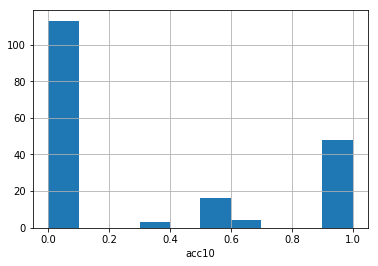

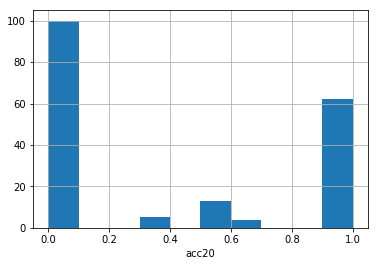

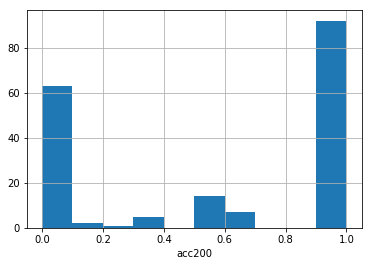

In [53]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()